## Local minimization of multivariate scalar functions (`minimize`)
https://docs.scipy.org/doc/scipy/tutorial/optimize.html
### Unconstrained minimization
#### Nelder-Mead simplex algorithm (`method='Nelder-Mead'`)

In [2]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Circle

plt.style.use(r"C:\Users\B30724\Documents\Python\presentation.mplstyle")

Example objective function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$
$$ f(x,y) = 1-\text{e}^{-\left[(x-1)^2 + (x-1)(y-1) + \frac{1}{2}(y-1)^2 \right]} $$

This function has minimum of 0 at $(x,y)=(1,1)$.

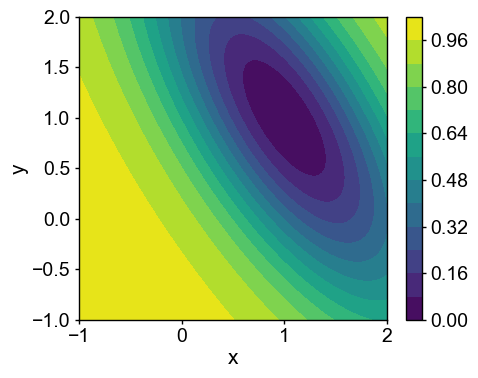

In [ ]:
x = np.linspace(-1,2,101)
y = np.linspace(-1,2,101)
xx, yy = np.meshgrid(x, y)
func = lambda X, Y: 1 - np.exp(-((X-1)**2 + (X-1)*(Y-1) + 0.5*(Y-1)**2))

fig, ax = plt.subplots(figsize=(5,4))
ax.set(xlabel='x', ylabel='y')
img = ax.contourf(xx, yy, func(xx, yy), levels=12)  # levels=[0,1e-3,5e-3,1e-2]+list(np.linspace(0.1,1,10))
# img = ax.pcolormesh(xx, yy, func(xx, yy))
fig.colorbar(img, ax=ax)
fig.tight_layout()


In [11]:
def objective(x):
    return 1 - np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))

x0 = np.array([0.0, 0.0])
res1 = minimize(objective, x0, method='nelder-mead', tol=1e-6, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 85
         Function evaluations: 159


In [12]:
print(res1.x)

[0.99999968 0.99999984]


#### Broyden-Fletcher-Goldfarb-Shanno algorithm (`method='BFGS'`)
The gradient of a multivariate function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ is a vector of $\mathbb{R}^2$ depending on $(x,y)$:
$$ \nabla f(x,y) = \begin{bmatrix}\partial_x f(x,y) \\ \partial_y f(x,y) \end{bmatrix}$$
More generally, the gradient of a multivariate function $f: \mathbb{R}^N \rightarrow \mathbb{R}$ is:
$$ \nabla f(\mathbf{x}_0) = \begin{bmatrix}\frac{\partial f}{\partial x_1}(\mathbf{x}_0) \\ \vdots \\ \frac{\partial f}{\partial x_N}(\mathbf{x}_0) \end{bmatrix}$$
Without providing gradient in `minimize(method='BFGS')`, the gradient is estimated on the fly.

In [13]:
res2 = minimize(objective, x0, method='BFGS', tol=1e-6, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 27
         Gradient evaluations: 9


In [14]:
print(res2.x)

[1.00000003 0.99999932]


Gradient of the example function written as:
$$ \begin{align}
\frac{\partial f}{\partial x} &= \left[ 2(x-1)+(y-1) \right] \text{e}^{-\left[(x-1)^2 + (x-1)(y-1) + \frac{1}{2}(y-1)^2 \right]} \\
\frac{\partial f}{\partial y} &= \left[ (x-1)+(y-1) \right] \text{e}^{-\left[(x-1)^2 + (x-1)(y-1) + \frac{1}{2}(y-1)^2 \right]}
\end{align} $$

In [15]:
def derivative(x):
    dfdx = (2*(x[0]-1) + x[1]-1) * np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
    dfdy = (x[0]-1 + x[1]-1) * np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
    return np.array([dfdx, dfdy])

res3 = minimize(objective, x0, method='BFGS', jac=derivative, tol=1e-6, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9


In [16]:
print(res3.x)

[1.00000004 0.99999932]


#### Newton-Conjugate-Gradient algorithm (`method='Newton-CG'`)
Newton's method is based on fitting the function locally to a quadratic form:
$$
f(\mathbf{x}) \approx f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0) \cdot (\mathbf{x}-\mathbf{x}_0) + \frac{1}{2} (\mathbf{x}-\mathbf{x}_0)^T \mathbf{H}(\mathbf{x}_0) (\mathbf{x}-\mathbf{x}_0)
$$
where $\mathbf{H}(\mathbf{x}_0)$ is a matrix of second derivatives (the __Hessian__). If the Hessian is positive definite, then the local minimum can be found by setting the gradient of this approximation (with respect to $\mathbf{x}-\mathbf{x}_0$) to zero, resulting in
$$
\mathbf{x_{opt}} = \mathbf{x_0} - \mathbf{H}^{-1}\nabla f
$$
To take full advantage of the Newton-CG method, a function which computes the Hessian must be provided. The inverse of the Hessian is evaluated using the conjugate-gradient method. The Hessian matrix itself does not need to be constructed, only a vector which is the product of the Hessian with an arbitrary vector needs to be available to the minimization routine. As a result, the user can provide either a function to compute the Hessian matrix, or a function to compute the product of the Hessian with an arbitrary vector.

- Full Hessian example
$$ \begin{align}
\frac{\partial^2 f}{\partial x^2} &= \left[2 - \left(2(x-1)+(y-1)\right)^2\right] \text{e}^{-\left[(x-1)^2 + (x-1)(y-1) + \frac{1}{2}(y-1)^2 \right]} \\
\frac{\partial^2 f}{\partial x \partial y} &= \left[1 - \left(2(x-1)+(y-1)\right)\left((x-1)+(y-1)\right)\right] \text{e}^{-\left[(x-1)^2 + (x-1)(y-1) + \frac{1}{2}(y-1)^2 \right]} \\
\frac{\partial^2 f}{\partial y \partial x} &= \frac{\partial^2 f}{\partial x \partial y} \\
\frac{\partial^2 f}{\partial y^2} &= \left[1 - \left((x-1)+(y-1)\right)^2\right] \text{e}^{-\left[(x-1)^2 + (x-1)(y-1) + \frac{1}{2}(y-1)^2 \right]}
\end{align} $$

In [17]:
def hessian(x):
    dfdxdx = (2 - (2*(x[0]-1) + x[1]-1)**2) * np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
    dfdxdy = (1 - (2*(x[0]-1) + x[1]-1)*(x[0]-1 + x[1]-1)) * np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
    dfdydy = (1 - (x[0]-1 + x[1]-1)**2) * np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
    H = np.array([[dfdxdx, dfdxdy],[dfdxdy, dfdydy]])
    return H

res4 = minimize(objective, x0, method='Newton-CG',
                jac=derivative, hess=hessian, tol=1e-6, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 4


In [18]:
print(res4.x)

[1. 1.]


- Hessian product example

For larger minimization problems, storing the entire Hessian matrix can consume considerable time and memory. The Newton-CG algorithm only needs the product of the Hessian times an arbitrary vector. As a result, the user can supply code to compute this product rather than the full Hessian by giving a `hess` function which take the minimization vector as the first argument and the arbitrary vector as the second argument (along with extra arguments passed to the function to be minimized).

In [19]:
def hessian_p(x, p):
    dfdxdx = (2 - (2*(x[0]-1) + x[1]-1)**2) * np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
    dfdxdy = (1 - (2*(x[0]-1) + x[1]-1)*(x[0]-1 + x[1]-1)) * np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
    dfdydy = (1 - (x[0]-1 + x[1]-1)**2) * np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
    Hp = np.array([dfdxdx*p[0] + dfdxdy*p[1], dfdxdy*p[0] + dfdydy*p[1]])
    return Hp

res5 = minimize(objective, x0, method='Newton-CG',
                jac=derivative, hessp=hessian_p, tol=1e-6, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 7


In [20]:
print(res5.x)

[1. 1.]


### Constrained minimization
Types of constraints:
- Bounds: $\text{lb}_i \leq x_i \leq \text{ub}_i$, for each $i=1,...,N$
- Linear constraints
- Nonlinear constraints

Note that `BFGS` does not support constraints. `L-BFGS-B` supports only bounds. Use `SLSQP` or `trust-constr` for bounds and constraints.

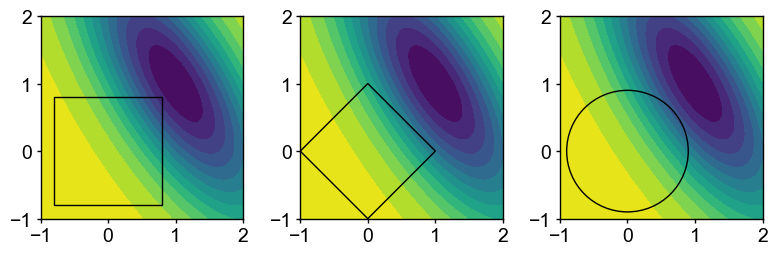

In [29]:
fig, axs = plt.subplots(1,3, figsize=(8,4))
for ax in axs:
    ax.contourf(xx, yy, func(xx, yy), levels=12)  # levels=[0,1e-3,5e-3,1e-2]+list(np.linspace(0.1,1,10))
    ax.set_aspect("equal")
axs[0].add_patch(Rectangle((-0.8,-0.8), 1.6, 1.6, lw=1, ec='k', fc='none'))
axs[1].add_patch(Polygon(np.vstack([[0,-1], [1,0], [0,1], [-1,0]]), lw=1, ec='k', fc='none'))
axs[2].add_patch(Circle((0, 0), 0.9, lw=1, ec='k', fc='none'))
fig.tight_layout()

In [53]:
res6 = minimize(objective, x0, method='L-BFGS-B', jac=derivative, tol=1e-6, 
                bounds=[(-0.8, 0.8), (-0.8, 0.8)])
if res6.success:
    print("Objective:", res6.fun)
    print(res6.x)

Objective: 0.09516258196404037
[0.8 0.8]


**Defining Linear Constraints**

The constraints:
$$ \begin{align}
x - y &\leq 1 \\
x + y &\leq 1 \\
-x + y &\leq 1 \\
-x - y &\leq 1
\end{align} $$
can be written in the linear constraint standard format:
$$
\begin{bmatrix}
-\infty\\-\infty\\-\infty\\-\infty
\end{bmatrix} \leq
\begin{bmatrix}
1 & -1 \\
1 & 1 \\
-1 & 1 \\
-1 & -1 \end{bmatrix}
\begin{bmatrix}
x \\ y
\end{bmatrix} \leq
\begin{bmatrix}
1 \\ 1 \\ 1 \\ 1
\end{bmatrix}
$$
and defined using a `LinearConstraint` object

In [55]:
linear_constraint = LinearConstraint([[1,-1], [1,1], [-1,1], [-1,-1]], [-np.inf]*4, [1]*4)
res7 = minimize(objective, x0, method='trust-constr', tol=1e-6, jac=derivative, # hess=hessian,
                constraints=[linear_constraint], options={'verbose': 1})

`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 11, CG iterations: 14, optimality: 8.99e-07, constraint violation: 0.00e+00, execution time: 0.007 s.


In [56]:
if res7.success:
    print("Objective:", res7.fun)
    print(res7.x)

Objective: 0.39373544723197995
[0.98150003 0.01823229]


**Defining Nonlinear Constraints**

The general form of constraints can be written as:
$$ c^l \leq c(\mathbf{x}) \leq c^u $$
Example constraint:
$$ x^2 + y^2 \leq 1 $$
is defined using a `NonlinearConstraint` object.

In [59]:
constraint = lambda x: x[0]**2+x[1]**2
jacobian = lambda x: [2*x[0], 2*x[1]]
nonlinear_constraint = NonlinearConstraint(constraint, -np.inf, 1, jac=jacobian)
res8 = minimize(objective, x0, method='trust-constr', tol=1e-6, jac=derivative, # hess=hessian,
                constraints=[nonlinear_constraint], options={'verbose': 1})

`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 13, CG iterations: 19, optimality: 3.53e-07, constraint violation: 0.00e+00, execution time: 0.01 s.


In [58]:
if res8.success:
    print("Objective:", res8.fun)
    print(res8.x)

Objective: 0.18127052698081692
[0.79999865 0.59999919]
